In [1]:
from IPython.display import Image, display


Displaying image: oranges.jpg


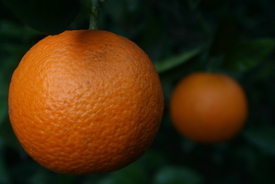


Displaying image: apple.jpg


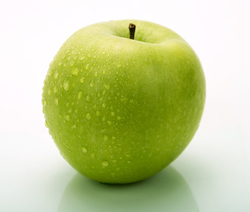


Displaying image: clock.jpg


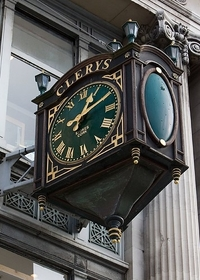


Displaying image: car.jpg


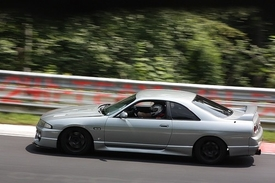

In [2]:
# Some example images
image_files = {
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
}

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

In [3]:
import os
dir_name = 'images_with_boxes'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [4]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

def detect_and_draw_box(filename, model='yolov3-tiny', confidence=0.5):
    # Read image
    img_filepath = f'images/{filename}'
    img = cv2.imread(img_filepath)

    # Perform inference
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)

    print(f"=============\nImages processed: {filename}\n")

    # Print detected objects with confidence
    for l,c in zip(label, conf):
        print(f"Detected object: {l} with confidence level {c}\n")

    output_image = draw_bbox(img, bbox, label, conf)
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    display(Image(f'images_with_boxes/{filename}'))

Images processed: oranges.jpg

Detected object: orange with confidence level 0.6185597777366638

Detected object: orange with confidence level 0.556171178817749



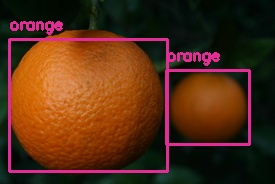

Images processed: apple.jpg

Detected object: apple with confidence level 0.5717152953147888



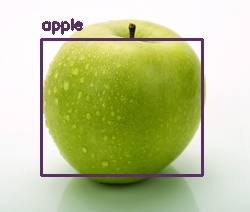

Images processed: clock.jpg

Detected object: clock with confidence level 0.9683184623718262



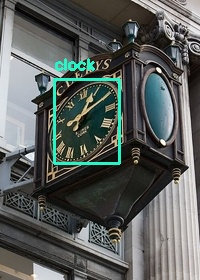

Images processed: car.jpg

Detected object: car with confidence level 0.632542073726654



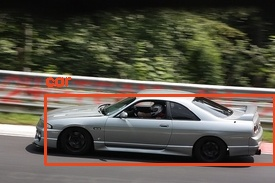

In [5]:
for image_file in image_files:
    detect_and_draw_box(image_file)

Images processed: fruits.jpg

Detected object: apple with confidence level 0.5818495154380798

Detected object: orange with confidence level 0.5346460938453674

Detected object: orange with confidence level 0.5151016116142273



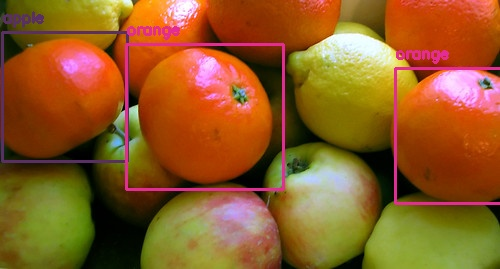

In [6]:
detect_and_draw_box('fruits.jpg')

Images processed: fruits.jpg

Detected object: apple with confidence level 0.5818495154380798

Detected object: orange with confidence level 0.5346460938453674

Detected object: orange with confidence level 0.5151016116142273

Detected object: apple with confidence level 0.3476002812385559

Detected object: orange with confidence level 0.3287639021873474

Detected object: apple with confidence level 0.31244754791259766

Detected object: orange with confidence level 0.27985963225364685

Detected object: orange with confidence level 0.2749984860420227

Detected object: apple with confidence level 0.27445200085639954

Detected object: orange with confidence level 0.21418967843055725



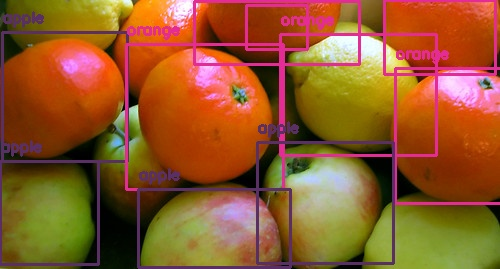

In [7]:
detect_and_draw_box("fruits.jpg", confidence=0.2)


In [8]:
dir_name = 'images_uploaded'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [9]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [10]:
app = FastAPI(title="Deploying an ML model with FastAPI")

In [11]:
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"

In [12]:
print(list(Model))

[<Model.yolov3tiny: 'yolov3-tiny'>, <Model.yolov3: 'yolov3'>]


In [13]:
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."

In [14]:
@app.post('/predict')
def prediction(model: Model, file: UploadFile = File(...)):

    ### 1. Validate input file ###
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ('jpg', 'jpeg', 'png')
    if not fileExtension:
        raise HTTPException(status_code=415, deyail="Unsupported file provided.")

    ### 2. Transform raw image to cv2 image ###

    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())

    # Start the stream from the beginning (position zero)
    image_stream.seek(0)

    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)

    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    ### 3. Run the detection model ##

    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)

    # Create image with bbox and labels
    output_image = draw_bbox(image, bbox, label, conf)

    # Save image in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)

    ### 4. Stream the response back to the client ###

    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode='rb')

    # Return the image as a stream specifying the media type
    return StreamingResponse(file_image, media_type='image/jpeg')

In [15]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [6163]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62797 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:62797 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:62798 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [6163]
